# Modeling with PSF

This notebook is just meant for testing the PSF variable response to accuracy as psf cannot be tested with test.csv for submission.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

# Set random seed.
#np.random.seed(42)


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Reading csv

In [2]:
df_train_psf = pd.read_csv("../data/train_cleaned_dummies_no_out_psf.csv")
#df_train = pd.read_csv("../data/train_cleaned_dummies_no_out.csv")
#df_test = pd.read_csv("../data/test_dummies_matched.csv")
#df_test_original = pd.read_csv("../data/test.csv")
pd.set_option('display.max_columns', 4000)
pd.set_option('display.max_rows', 4000)

In [3]:
df_train_psf.head(2)

,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,age,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_CompShg,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsbShng,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsbShng,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Central Air_N,Central Air_Y,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_None,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Utilities_AllPub,Utilities_NoSewr,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Bsmt Exposure_Av,Bsmt Exposure_Gd,Bsmt Exposure_Mn,Bsmt Exposure_No,Bsmt Exposure_None,BsmtFin Type 1_ALQ,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_None,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,BsmtFin Type 2_ALQ,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_None,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,Garage Finish_Fin,Garage Finish_None,Garage Finish_RFn,Garage Finish_Unf,Paved Drive_N,Paved Drive_P,Paved Drive_Y,psf
0,533352170,60,55.23,13517,6,8,1976,2005,289.0,4,3,3,3,533.0,0.0,192.0,725.0,5,725,754,0,1479,0.0,0.0,2,1,3,1,4,6,0,0,1976.0,2.0,475.0,3,3,0,44,0,0,0,0,0,3,2010,130500,34,0,0,0,0,1,0,0,1,0,0,0,1

## Setting X and y variables

In [4]:
features = [col for col in df_train_psf._get_numeric_data().columns if col != 'SalePrice']

In [5]:
#Assigning X and Y variables for modelling
cols = ['SalePrice']
X = df_train_psf.drop(cols, axis=1)
#X = df_train_psf[features]
y = df_train_psf['SalePrice']

In [6]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2)

In [7]:
# Scaling X_train
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

### Null Model

In [8]:
df_train_psf["SalePrice"].mean()

181650.0423814329

In [9]:
#Creating a new column in df for Null RMSE calculation
df_train_psf["y_mean"] = df_train_psf["SalePrice"].mean()
df_train_psf.head(5)

,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating QC,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Fireplaces,Fireplace Qu,Garage Yr Blt,Garage Cars,Garage Area,Garage Qual,Garage Cond,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,age,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,Street_Grvl,Street_Pave,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Config_Corner,Lot Config_CulDSac,Lot Config_FR2,Lot Config_FR3,Lot Config_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_Greens,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Bldg Type_1Fam,Bldg Type_2fmCon,Bldg Type_Duplex,Bldg Type_Twnhs,Bldg Type_TwnhsE,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Roof Style_Flat,Roof Style_Gable,Roof Style_Gambrel,Roof Style_Hip,Roof Style_Mansard,Roof Style_Shed,Roof Matl_CompShg,Roof Matl_Tar&Grv,Roof Matl_WdShake,Roof Matl_WdShngl,Exterior 1st_AsbShng,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,Exterior 2nd_AsbShng,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Central Air_N,Central Air_Y,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_None,Sale Type_COD,Sale Type_CWD,Sale Type_Con,Sale Type_ConLD,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_WD,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,Utilities_AllPub,Utilities_NoSewr,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Bsmt Exposure_Av,Bsmt Exposure_Gd,Bsmt Exposure_Mn,Bsmt Exposure_No,Bsmt Exposure_None,BsmtFin Type 1_ALQ,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_None,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,BsmtFin Type 2_ALQ,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_None,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,Garage Finish_Fin,Garage Finish_None,Garage Finish_RFn,Garage Finish_Unf,Paved Drive_N,Paved Drive_P,Paved Drive_Y,psf,y_mean
0,533352170,60,55.23,13517,6,8,1976,2005,289.0,4,3,3,3,533.0,0.0,192.0,725.0,5,725,754,0,1479,0.0,0.0,2,1,3,1,4,6,0,0,1976.0,2.0,475.0,3,3,0,44,0,0,0,0,0,3,2010,130500,34,0,0,0,0,1,0,0,1,

In [10]:
print( "Null RMSE: ",np.sqrt(metrics.mean_squared_error(df_train_psf["SalePrice"], df_train_psf["y_mean"])))

Null RMSE:  78038.64079689019


## Model 1 - Linear Regression

In [11]:
#initiating linear regression and fitting data
ols = LinearRegression()
ols.fit(Z_train, y_train)

LinearRegression()

In [12]:
ols_scores = cross_val_score(ols, Z_train, y_train, cv=5)
print(ols_scores.mean())

0.9473750929168198


In [13]:
#printing R2 score for linear regression
print(ols.score(Z_train, y_train))
print(ols.score(Z_test, y_test))

1.0
1.0


## Model 2 - Lasso Regression

In [14]:
#initiating lasso cv and fitting data
#folds  = 5
optimal_lasso = LassoCV(cv = 5)
optimal_lasso.fit(Z_train, y_train)

LassoCV(cv=5)

In [15]:
optimal_lasso.alpha_

79.34811426105982

In [16]:
print("Model RMSE (train split): ", np.sqrt(metrics.mean_squared_error(y_train, optimal_lasso.predict(Z_train))))

Model RMSE (train split):  86.92110614155791


In [17]:
print("Model RMSE (test split): ", np.sqrt(metrics.mean_squared_error(y_test, optimal_lasso.predict(Z_test))))

Model RMSE (test split):  75.68810732752102


In [18]:
metrics.r2_score(y_train, optimal_lasso.predict(Z_train))

0.9999988000310627

In [19]:
metrics.r2_score(y_test, optimal_lasso.predict(Z_test))

0.9999989102596987

## Model 3 - Ridge Regression

In [20]:
#initiating ridge cv and fitting data
optimal_ridge = RidgeCV(cv = 5)
optimal_ridge.fit(Z_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=5)

In [21]:
optimal_ridge.alpha_

0.1

In [22]:
print("Model RMSE (train split): ", np.sqrt(metrics.mean_squared_error(y_train, optimal_ridge.predict(Z_train))))

Model RMSE (train split):  20.2836070473151


In [23]:
print("Model RMSE (test split): ", np.sqrt(metrics.mean_squared_error(y_test, optimal_ridge.predict(Z_test))))

Model RMSE (test split):  26.257789676273976


In [24]:
metrics.r2_score(y_train, optimal_ridge.predict(Z_train))

0.9999999346553717

In [25]:
metrics.r2_score(y_test, optimal_ridge.predict(Z_test))

0.9999998688452414

<AxesSubplot:>

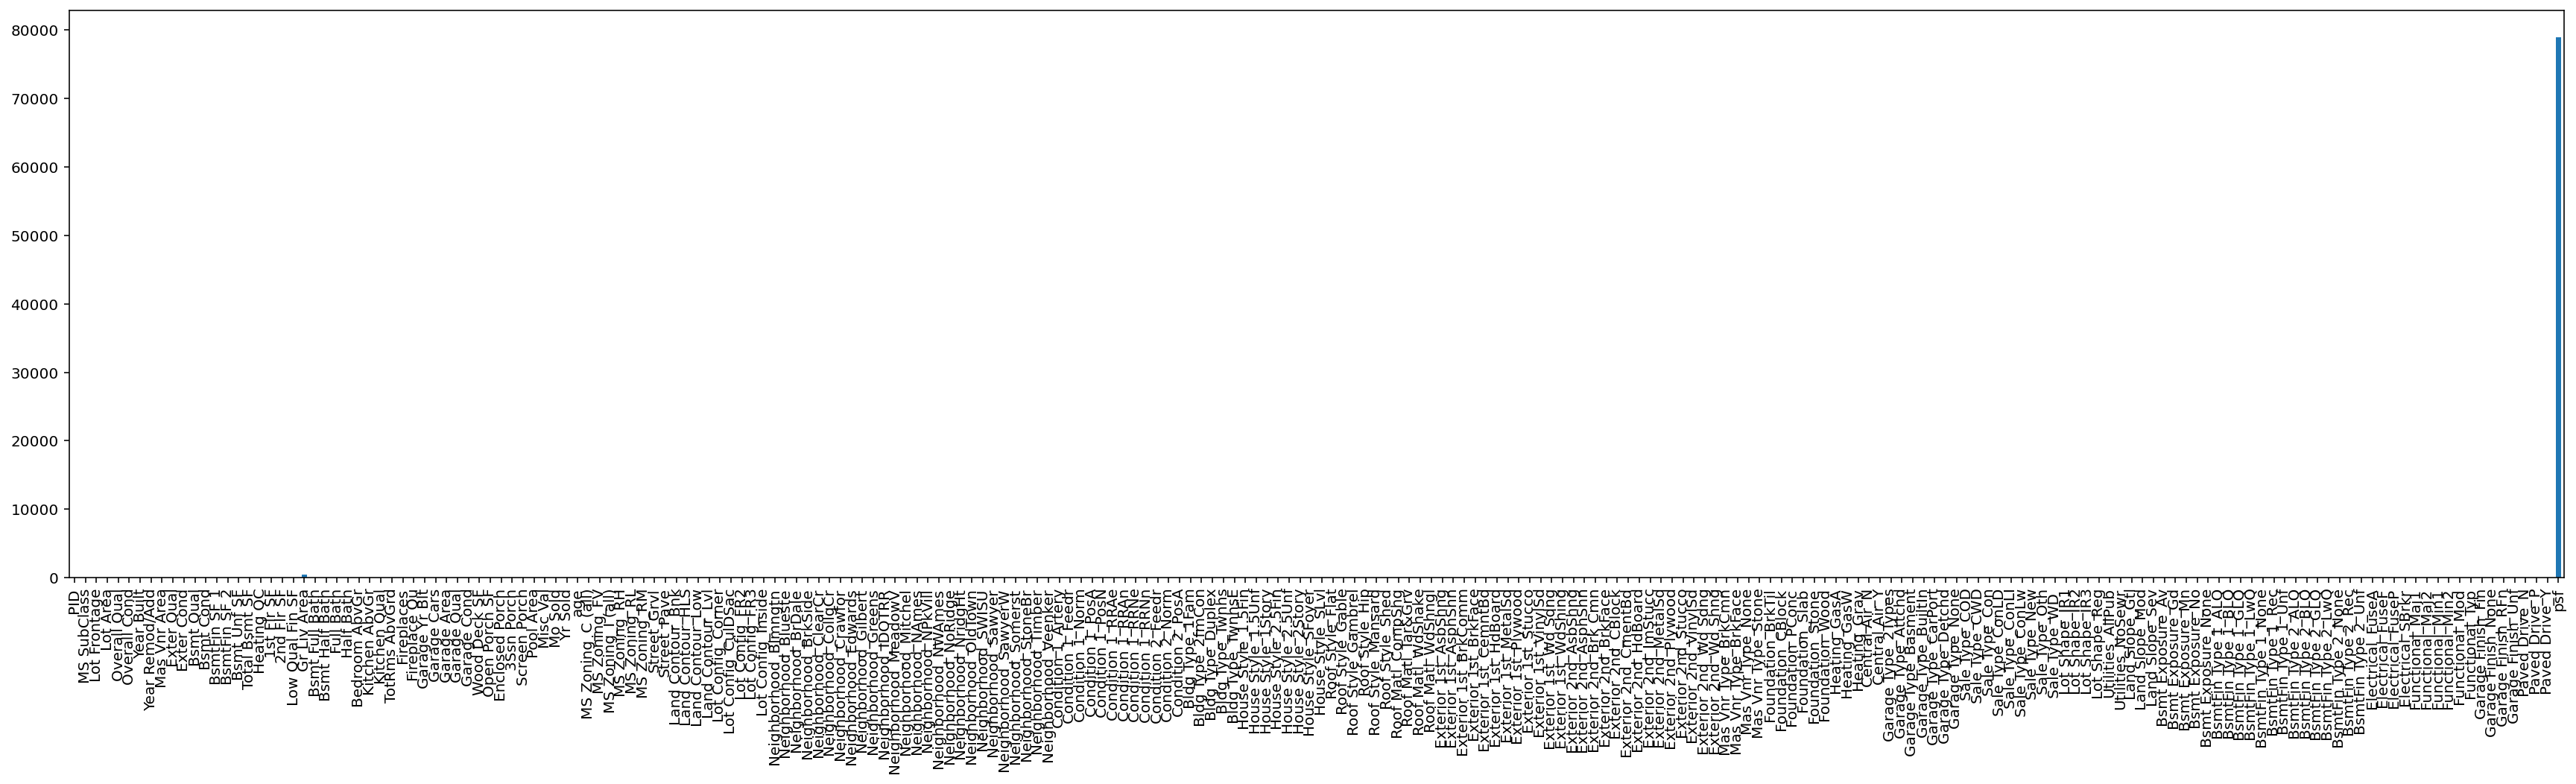

In [26]:
pd.Series(optimal_lasso.coef_, index=features).plot.bar(figsize=(30, 7))

<AxesSubplot:>

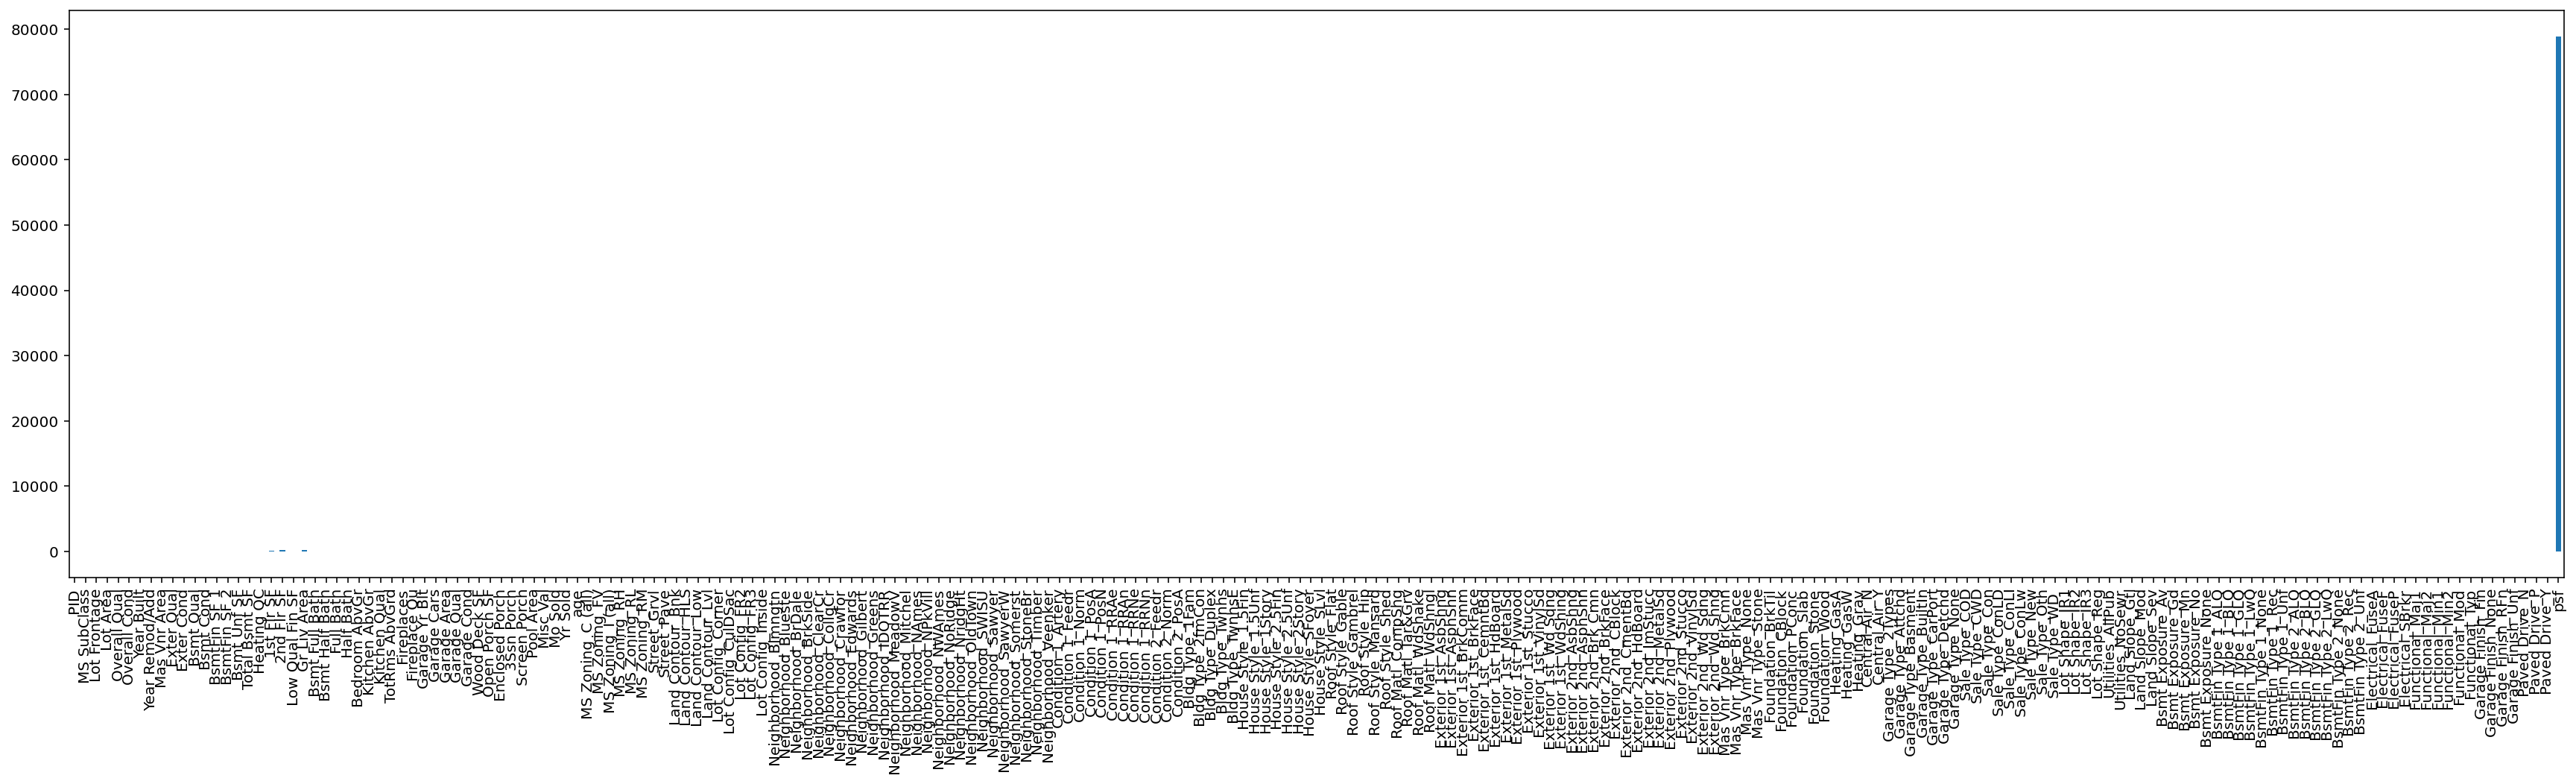

In [27]:
pd.Series(optimal_ridge.coef_, index=features).plot.bar(figsize=(30, 7))

/Users/as/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


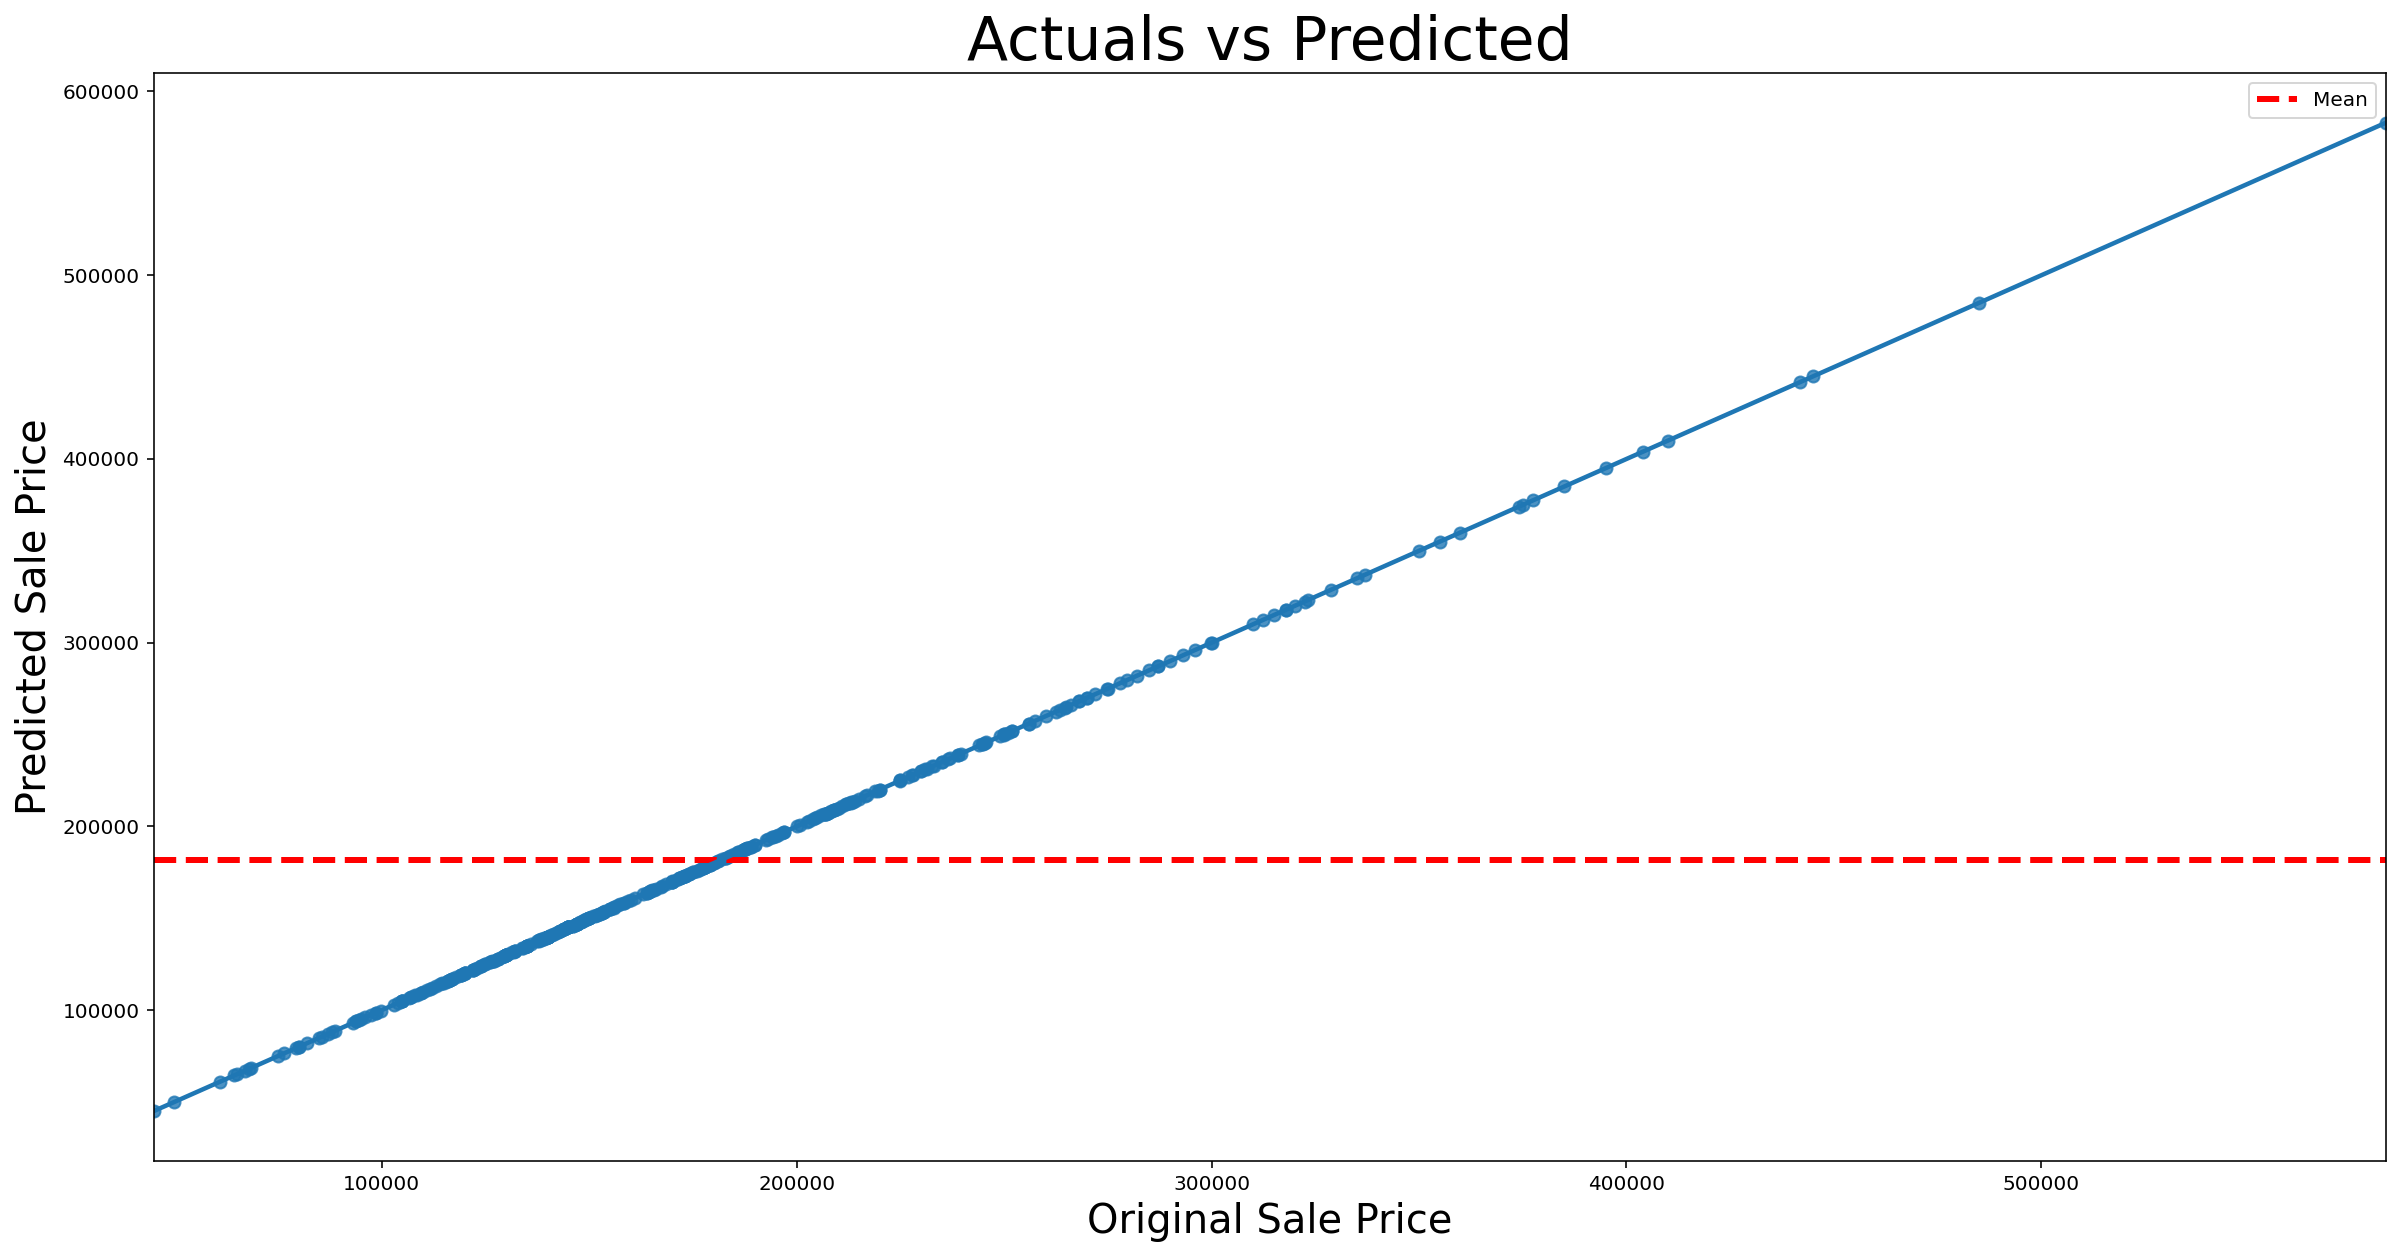

In [28]:
fig, ax = plt.subplots(figsize=(20,10))
plt.axhline(df_train_psf["SalePrice"].mean(), ls='--', linewidth=3, color = 'red', label = "Mean")
sns.regplot(y_test, optimal_ridge.predict(Z_test))
ax.set_xlabel( "Original Sale Price", size = 20) 
ax.set_ylabel( "Predicted Sale Price", size = 20) 
ax.set_title( "Actuals vs Predicted", size = 30)
plt.legend()
plt.savefig('../images/actual_vs_predicted.png')
plt.show()

### Inputting PSF gave the model 99.99% accuracy
This meant that psf is the no.1 variable for predicting price of the property. It is probably why it was taken out of the test.csv dataset.